## Graph classification task with DGL

Perform batched graph classification of 8 types of regular graphs. We use a dataset that has 8 different types of graphs and each class has the same number of graph samples.[link text](https://)

In [1]:
!pip install dgl

    100% |████████████████████████████████| 747kB 21.3MB/s 


In [0]:
from dgl.data import MiniGCDataset
import dgl
import dgl.function as fn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import networkx as nx

In [0]:
# Load dataset with 80 samples, each graph is of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)

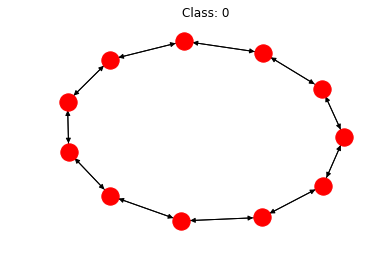

In [4]:
# Plot sample graph
graph, label = dataset[0]

fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

Define a function that form a mini-batch from a given list of graph and label pairs.

In [0]:
def collate(samples):
    # The input `samples` is a list of pairs (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    
    return batched_graph, torch.tensor(labels)

In [0]:
def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

In [0]:
class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

In [0]:
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

### Readout and Classification

For this demonstration, we consider initial node features to be their degrees. After two rounds of graph convolution, we perform a graph readout by averaging over all node features for each graph in the batch

In [0]:
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = g.in_degrees().view(-1, 1).float()
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

From a batch of graphs, we first perform message passing/graph convolution for nodes to “communicate” with others. After message passing, we compute a tensor for graph representation from node (and edge) attributes. This step may be called “readout/aggregation” interchangeably. Finally, the graph representations can be fed into a classifier to predict the graph labels.

In [0]:
# Sends a message of node feature h.
msg = fn.copy_src(src='h', out='m')

We create a synthetic dataset of 400 graphs with 10 ~ 20 nodes. 320 graphs constitute a training set and 80 graphs constitute a test set.

In [0]:
# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset  = MiniGCDataset(80, 10, 20)

In [0]:
# Use PyTorch's DataLoader and the collate function defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

In [0]:
# Create model
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
# Fit the model
model.train()

Classifier(
  (layers): ModuleList(
    (0): GCN(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=1, out_features=256, bias=True)
      )
    )
    (1): GCN(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
    )
  )
  (classify): Linear(in_features=256, out_features=8, bias=True)
)

In [28]:
epoch_losses = []

for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

/usr/local/lib/python3.6/dist-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


Epoch 0, loss 2.1371
Epoch 1, loss 1.9590
Epoch 2, loss 1.8599
Epoch 3, loss 1.7915
Epoch 4, loss 1.7003
Epoch 5, loss 1.6177
Epoch 6, loss 1.5214
Epoch 7, loss 1.4422
Epoch 8, loss 1.3950
Epoch 9, loss 1.3020
Epoch 10, loss 1.2261
Epoch 11, loss 1.1767
Epoch 12, loss 1.1317
Epoch 13, loss 1.0838
Epoch 14, loss 1.0535
Epoch 15, loss 1.0280
Epoch 16, loss 1.0012
Epoch 17, loss 0.9703
Epoch 18, loss 0.9344
Epoch 19, loss 0.9153
Epoch 20, loss 0.9253
Epoch 21, loss 1.0121
Epoch 22, loss 0.9326
Epoch 23, loss 0.8844
Epoch 24, loss 0.8529
Epoch 25, loss 0.8292
Epoch 26, loss 0.8077
Epoch 27, loss 0.7918
Epoch 28, loss 0.7825
Epoch 29, loss 0.7891
Epoch 30, loss 0.7789
Epoch 31, loss 0.7504
Epoch 32, loss 0.7503
Epoch 33, loss 0.7226
Epoch 34, loss 0.7208
Epoch 35, loss 0.7336
Epoch 36, loss 0.7325
Epoch 37, loss 0.7716
Epoch 38, loss 0.7370
Epoch 39, loss 0.7177
Epoch 40, loss 0.6924
Epoch 41, loss 0.6746
Epoch 42, loss 0.6703
Epoch 43, loss 0.6694
Epoch 44, loss 0.6485
Epoch 45, loss 0.633

### Plot learning curve

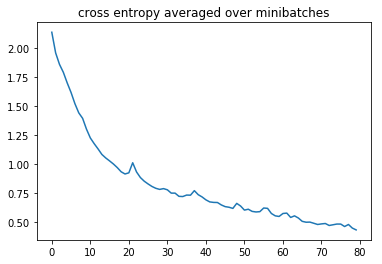

In [29]:
# The learning curve of a run is presented below.
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

The trained model is evaluated on the test set created.

In [30]:
# Evaluate model
model.eval()

Classifier(
  (layers): ModuleList(
    (0): GCN(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=1, out_features=256, bias=True)
      )
    )
    (1): GCN(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
    )
  )
  (classify): Linear(in_features=256, out_features=8, bias=True)
)

In [31]:
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 70.0000%
Accuracy of argmax predictions on the test set: 73.750000%


/usr/local/lib/python3.6/dist-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)
